In [1]:
#Handing data 
import pandas as pd
import numpy as np
#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set_theme()
#Pymoo multi-objective optimization 
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.core.population import Population
#Finance libraries 
import yfinance as yf
import yesg
#Plugins
from tqdm import tqdm #Timing iteration
#from itertools import compress 
from Plugins import pre_processing
from Plugins import ArchievingStrategies
from Plugins import my_plotting
from Plugins import pymoo_extras
from Plugins import DS
from Plugins import evaluation
#Finance libraries 
from finquant import efficient_frontier

In [2]:
## NUMBER OF ASSETS
n_assets = 7 #Assets
freq = 252  #days period
n_obs = 252*2 #n_obs 252

#seed = np.random.randint(0,10000)
seed = np.random.randint(0, 10000)
rng = np.random.default_rng(seed)
## random weights 
n_portfolios = 10000
def rand_weights(n_portfolios, n_assets):
    ''' Produces n random weights that sum to 1 '''
    k = rng.random((n_portfolios, n_assets))
    return k / np.sum(k, axis=1, keepdims=True)


returns_vec = rng.normal(loc=0, scale=0.01, size=(n_obs, n_assets))
print(np.mean(returns_vec,axis=0))
while np.any(0 > np.mean(returns_vec, axis=0)): 
   if np.sum(np.mean(returns_vec))*freq > 0.3: 
       seed = np.random.randint(0, 10000)
       continue
   seed = np.random.randint(0, 10000)
   rng = np.random.default_rng(seed)
   returns_vec = rng.normal(loc=0, scale=0.01, size=(n_obs, n_assets))
returns =pd.DataFrame(returns_vec, columns = ['s'+str(i+1) for i in range(n_assets)])
assets_info = pd.DataFrame()

assets_info["exp_risk"]=returns.std()*np.sqrt(freq)
assets_info["exp_return"]=-returns.mean()*freq
assets_info['esg_score'] = rng.random((n_assets))

print(seed)
assets_info

[ 9.82532617e-05  7.78687535e-04  2.01336415e-04 -1.99177125e-05
  1.18770483e-04  3.62253847e-04  3.05164963e-05]
8356


,exp_risk,exp_return,esg_score
s1,0.165381,-0.045795,0.382027
s2,0.151559,-0.034581,0.384366
s3,0.157636,-0.141152,0.830854
s4,0.156794,-0.050706,0.034306
s5,0.162256,-0.085423,0.322153
s6,0.161407,-0.028993,0.026063
s7,0.152942,-0.117400,0.213100


In [3]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(returns, assets_info)
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES) #Negative return (for minimize)

In [4]:
ef = efficient_frontier.EfficientFrontier(pd.Series(PROFITS), pd.DataFrame(RISK), freq=252)
min_vol_weights = ef.minimum_volatility(save_weights=False)
min_return = -portfolio_problem.evaluate(min_vol_weights)[1]*252 #Positive return (for maximize)
max_return = np.max(PROFITS)*252
targets = np.linspace(round(min_return, 8), round(max_return, 8), 100)
ef_R = ef.efficient_frontier(targets=targets)

In [5]:
eps = np.array([0.01,0.01])
colors = ['#f0f2fa','#8da0cb', '#1b9e77']

In [6]:
X_dummy = rand_weights(int(1e4),n_assets)
F_dummy, ESG_dummy =pymoo_extras.eval_weights(portfolio_problem, X_dummy)
FA_dummy =  pymoo_extras.annualised_portfolio_quantities(F_dummy)
FA_dummy_best_eps = ArchievingStrategies.get_best_opt_eps(FA_dummy, 1e-6, eps)
FA_dummy_best = ArchievingStrategies.get_best_opt(FA_dummy_best_eps, 1e-6)
print('Total', FA_dummy.shape)
print('Eps-Mejores', FA_dummy_best_eps.shape)
print('Mejores', FA_dummy_best.shape)

10000it [00:06, 1477.02it/s]
7566it [00:00, 38052.58it/s]

Total (10000, 2)
Eps-Mejores (7566, 2)
Mejores (42, 2)


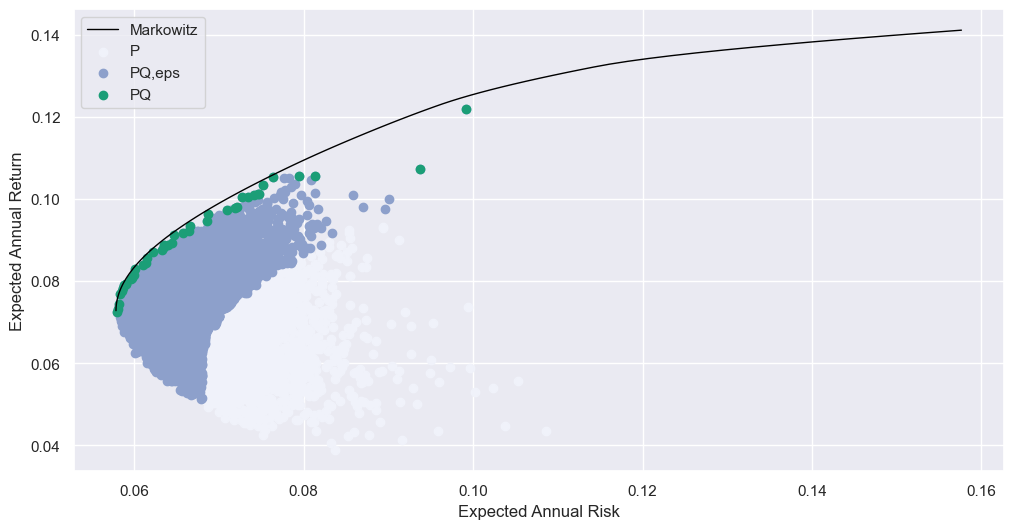

In [7]:
frames = [FA_dummy, FA_dummy_best_eps, FA_dummy_best]
labels = ['P', 'PQ,eps', 'PQ']
fig1 = my_plotting.plotting_samples(ef_R, frames, labels, colors, (12, 6))

In [8]:
FA_3D = FA_dummy_best_eps.copy()
FA_3D['exp_esg'] = ESG_dummy[FA_dummy_best_eps.index]
FA_3D_best       = ArchievingStrategies.get_best_opt(FA_3D, 1e-6)

7566it [00:00, 19458.41it/s]


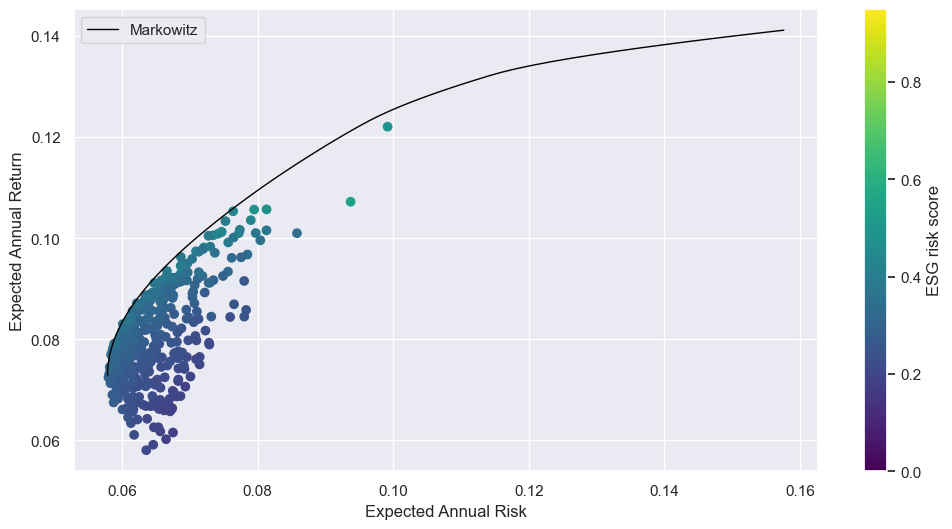

In [9]:
fig2 =my_plotting.plotting_projection(FA_3D_best, ef_R, (12,6), colormap='viridis', vmin=0.0, vmax=0.95) 

## Comments for Directed Search

In [10]:
X_mkds = DS.get_Markowitz_directions(ef, PROFITS, RISK, min_return, max_return, eps, size=50, steps=10)
F_mkds, ESG_mkds = pymoo_extras.eval_weights(portfolio_problem, X_mkds)
FA_mkds =  pymoo_extras.annualised_portfolio_quantities(F_mkds)
FA_mkds_best_eps = ArchievingStrategies.get_best_opt_eps(FA_mkds, 1e-6, eps)
FA_mkds_best = ArchievingStrategies.get_best_opt(FA_mkds_best_eps, 1e-6)
print('Total', FA_mkds.shape)
print('Mejores', FA_mkds_best.shape)
print('Eps-Mejores', FA_mkds_best_eps.shape)

500it [00:00, 7465.14it/s]
500it [00:00, 10670.36it/s]

Total (500, 2)
Mejores (352, 2)
Eps-Mejores (500, 2)


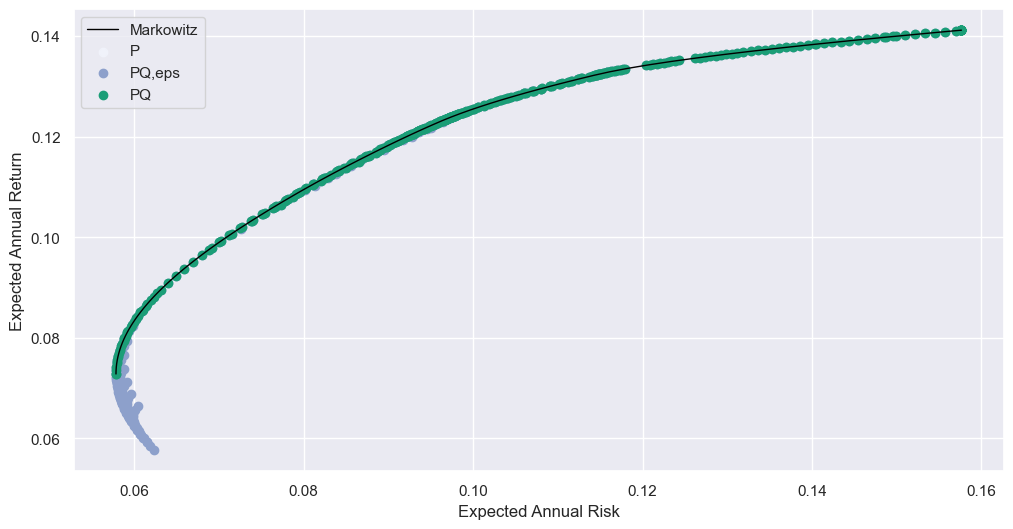

In [11]:
frames = [FA_mkds, FA_mkds_best_eps, FA_mkds_best]
labels = ['P', 'PQ,eps', 'PQ']
fig1 = my_plotting.plotting_samples(ef_R, frames, labels, colors, (12, 6))

In [12]:
def get_Markowitz_unconstrained_directions(ef,PROFITS, RISK,min_return, max_return, eps,size=50, steps=10,tol=1e-12,learn_rate=0.001,  
                            n_iter=1000, freq=252):
    #Get the optimal results first 
    X_ef = DS.efficient_frontier_weights(ef, min_return, max_return, size)
    ds = DS.DirectedSearch(PROFITS, RISK, eps, tol, learn_rate, n_iter, freq)
    X_ef_new = ds.directed_search_full_space(X_ef, steps)
    return X_ef_new[:]

In [13]:
X_mkdsnot = get_Markowitz_unconstrained_directions(ef, PROFITS, RISK, min_return, max_return, eps, size=50, steps=10)
F_mkdsnot, ESG_mkdsnot = pymoo_extras.eval_weights(portfolio_problem, X_mkdsnot)
FA_mkdsnot =  pymoo_extras.annualised_portfolio_quantities(F_mkdsnot)
FA_mkdsnot_best_eps = ArchievingStrategies.get_best_opt_eps(FA_mkdsnot, 1e-6, eps)
FA_mkdsnot_best = ArchievingStrategies.get_best_opt(FA_mkdsnot_best_eps, 1e-6)
print('Total', FA_mkds.shape)
print('Mejores', FA_mkds_best.shape)
print('Eps-Mejores', FA_mkds_best_eps.shape)

500it [00:00, 7154.05it/s]
473it [00:00, 23081.55it/s]

Total (500, 2)
Mejores (352, 2)
Eps-Mejores (500, 2)


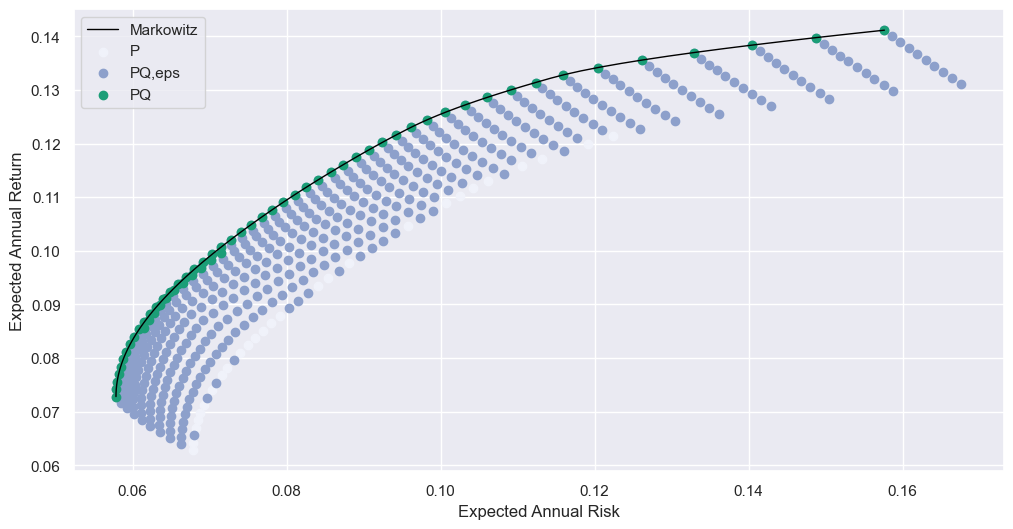

In [14]:
frames = [FA_mkdsnot, FA_mkdsnot_best_eps, FA_mkdsnot_best]
labels = ['P', 'PQ,eps', 'PQ']
fig1 = my_plotting.plotting_samples(ef_R, frames, labels, colors, (12, 6))

## Final results 

In [16]:
report0 = pd.read_csv('FinalResults/sp500.csv')
report1 = pd.read_csv('FinalResults/dowjones.csv')
report2 = pd.read_csv('FinalResults/nasdaq100.csv')
reports = pd.concat([report0, report1, report2])

In [18]:
reports.columns

Index(['BursatilIndex', 'Sampling Method', 'Indicator', 'Execution',
       'Ind_Value'],
      dtype='object')

In [25]:
reports_groups =reports.groupby(['Indicator', 'BursatilIndex', 'Sampling Method'], as_index=False).agg({'Ind_Value': ['mean', 'std']})
reports_groups_HV = reports_groups[reports_groups['Indicator']=='HV']
reports_groups_HV[['BursatilIndex', 'Sampling Method', 'Ind_Value']]

BursatilIndex Sampling Method Ind_Value          
                                      mean       std
24      dowjones             das  1.101261  0.000000
25      dowjones            mkds  1.107397  0.000000
26      dowjones          nsgaii  1.107681  0.000025
27      dowjones             sms  1.107742  0.000365
28     nasdaq100             das  0.979601  0.000000
29     nasdaq100            mkds  0.991440  0.000000
30     nasdaq100          nsgaii  0.991479  0.000033
31     nasdaq100             sms  0.991793  0.000070
32         sp500             das  1.052160  0.000000
33         sp500            mkds  1.069357  0.000000
34         sp500          nsgaii  1.069147  0.000075
35         sp500             sms  1.065334  0.004085